# Table of Contents
- National Climate Dater Center
    - Column details
- NYCHA Building
    - Checking for NYCHA building and docking infor
- Citibikes
    - Looking at bike stations

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
from mofo_bikes.src.d01_preparation import HelperFn as fn
%load_ext autoreload
%autoreload 2

### NYC Weather data (NCDC)

Source:
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail

In [35]:
noaa = pd.read_csv('data/2070456.csv')
noaa_detailed = pd.read_csv('data/2070451.csv')

In [39]:
noaa.info()
noaa.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 22 columns):
STATION    2410 non-null object
NAME       2410 non-null object
DATE       2410 non-null object
AWND       2244 non-null float64
PGTM       1 non-null float64
PRCP       2410 non-null float64
SNOW       2409 non-null float64
SNWD       2410 non-null float64
TAVG       0 non-null float64
TMAX       2410 non-null int64
TMIN       2410 non-null int64
TSUN       1 non-null float64
WDF2       2247 non-null float64
WDF5       2233 non-null float64
WSF2       2247 non-null float64
WSF5       2233 non-null float64
WT01       822 non-null float64
WT02       46 non-null float64
WT03       55 non-null float64
WT04       5 non-null float64
WT06       14 non-null float64
WT08       451 non-null float64
dtypes: float64(17), int64(2), object(3)
memory usage: 414.3+ KB


(2410, 22)

In [24]:
noaa_detailed.columns = noaa_detailed.columns.str.lower()

In [33]:
NYC_coord = noaa_detailed.loc[:,['latitude','longitude']]

In [40]:
print(NYC_coord.shape)
NYC_coord.sample()

(2410, 2)

### NCDC column info
- STATION = USW00094728
- NAME = NY CITY CENTRAL PARK, NY US
- DATE = YYYY-MM-DD
- AWND = Average daily wind speed (meters per second or miles per hour as per user preference)
- PGTM = Peak gust time (hours and minutes, i.e., HHMM)

- 9’s in a field (e.g.9999) indicate missing data or data that has not been received.
    - PRCP = Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)
    - SNOW = Snowfall
    - SNWD = Snowdepth
    - TAVG = ? (all nan)
    - TMAX = Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths
    - TMIN = Minimum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths 
    - TSUN = Daily total sunshine (minutes)
    - WDF2 = Direction of fastest 2-minute wind (degrees)
    - WDF5 = Direction of fastest 5-**second** wind (degrees)
    - WSF2 = Fastest 2-minute wind speed (miles per hour or meters per second as per user preference)
    - WSF5 = Fastest 5-**second** wind speed (miles per hour or meters per second as per user preference)

- **WT** = Weather Type where ** has one of the following values: 
    - **01 = Fog, ice fog, or freezing fog (may include heavy fog)**
    - **02 = Heavy fog or heaving freezing fog (not always distinguished from fog)**
    - **03 = Thunder**
    - **04 = Ice pellets, sleet, snow pellets, or small hail**
    - 05 = Hail (may include small hail)
    - **06 = Glaze or rime**
    - 07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
    - **08 = Smoke or haze**
    - 09 = Blowing or drifting snow
    - 10 = Tornado, waterspout, or funnel cloud
    - 11 = High or damaging winds
    - 12 = Blowing spray
    - 13 = Mist
    - 14 = Drizzle
    - 15 = Freezing drizzle
    - 16 = Rain (may include freezing rain, drizzle, and freezing drizzle)
    - 17 = Freezing rain
    - 18 = Snow, snow pellets, snow grains, or ice crystals
    - 19 = Unknown source of precipitation
    - 21 = Ground fog
    - 22 = Ice fog or freezing fog

In [42]:
NYclimate = pd.concat([NYC_coord, noaa], axis =1)
NYclimate.shape

(2410, 24)

In [44]:
NYclimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 24 columns):
latitude     2410 non-null float64
longitude    2410 non-null float64
STATION      2410 non-null object
NAME         2410 non-null object
DATE         2410 non-null object
AWND         2244 non-null float64
PGTM         1 non-null float64
PRCP         2410 non-null float64
SNOW         2409 non-null float64
SNWD         2410 non-null float64
TAVG         0 non-null float64
TMAX         2410 non-null int64
TMIN         2410 non-null int64
TSUN         1 non-null float64
WDF2         2247 non-null float64
WDF5         2233 non-null float64
WSF2         2247 non-null float64
WSF5         2233 non-null float64
WT01         822 non-null float64
WT02         46 non-null float64
WT03         55 non-null float64
WT04         5 non-null float64
WT06         14 non-null float64
WT08         451 non-null float64
dtypes: float64(19), int64(2), object(3)
memory usage: 452.0+ KB


In [49]:
NYclimate['Raincheck']= 0
NYclimate['Raincheck']= NYclimate['PRCP']!=0

In [51]:
NYclimate.to_csv('NYC_climate.csv', index = False)

Prepare Visual for comparing min and max temperature, prcp with bike usage

# NYCHA Building Locations
Source:
https://data.cityofnewyork.us/Housing-Development/Map-of-NYCHA-Developments/i9rv-hdr5

In [3]:
#!pip install geopandas
#!pip install descartes #For ploting polygons
import geopandas

In [4]:
geospatial = geopandas.read_file('data/Map of NYCHA Developments.geojson')

In [5]:
print(type(geospatial))
geospatial.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


borough                   developmen tds_num  \
0      BRONX       1010 EAST 178TH STREET     180   
1   BROOKLYN       104-14 TAPSCOTT STREET     242   
2      BRONX  1162-1176 WASHINGTON AVENUE     233   
3  MANHATTAN    131 SAINT NICHOLAS AVENUE     154   
4      BRONX           1471 WATSON AVENUE     214   

                                            geometry  
0  MULTIPOLYGON (((-73.88092 40.84050, -73.88068 ...  
1  MULTIPOLYGON (((-73.92074 40.66492, -73.92076 ...  
2  MULTIPOLYGON (((-73.90695 40.83009, -73.90699 ...  
3  MULTIPOLYGON (((-73.95366 40.80416, -73.95364 ...  
4  MULTIPOLYGON (((-73.88104 40.82640, -73.88097 ...

The multiploygon cell is a polygon saved as a cell!

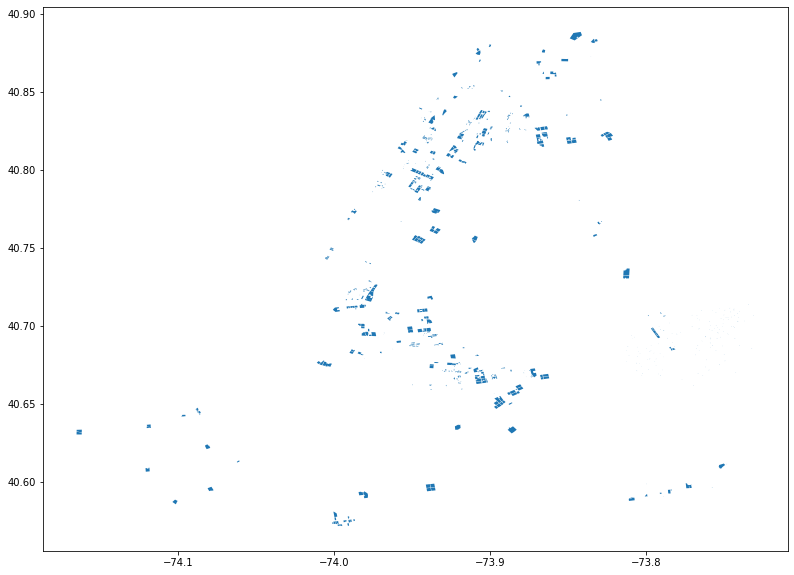

In [91]:
# Visualizing the data
plt.rcParams['figure.figsize'] = (20, 10)
geospatial.plot() #NYC Locations

In [6]:
# Plot larger visual
import folium

In [65]:
# NYCHA loctions
Manhattan = [40.76, -74.00]

m = folium.Map(location = Manhattan,
               tiles = 'OpenStreetMap',
               zoom_start = 12
              )

m.choropleth(geo_data = geospatial)

/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [66]:
m

In [67]:
bike2013 = pd.read_csv('data/citibike_data/2013-06-citibike-tripdata.csv')

In [69]:
dock2013 = bike2013.loc[:,['start station latitude','start station longitude']]
#dock2020 = bikes2020.loc[:,['start station latitude','start station longitude']]

In [70]:
dock2013.head()

start station latitude  start station longitude
0               40.742354               -73.989151
1               40.742354               -73.989151
2               40.695128               -73.995951
3               40.735243               -73.987586
4               40.705693               -74.016777

In [75]:
# Identifying duplicate rows
print('Activity in 2013 {}\n'.format(dock2013.shape) )
print(dock2013[ dock2013.duplicated() ].shape) #Returns dataframe of duplicated rows
dockloc = dock2013.drop_duplicates() 

Number of stations in 2013 (577703, 2)

(577366, 2)


In [78]:
dockloc = dockloc.reset_index()

In [79]:
?folium.CircleMarker

In [82]:
Manhattan = [40.76, -74.00]

m = folium.Map(location = Manhattan,
               tiles = 'OpenStreetMap',
               zoom_start = 12
              )

m.choropleth(geo_data = geospatial)

for i in range(dockloc.shape[0]):
    folium.CircleMarker(location =[dockloc['start station latitude'][i],
                                  dockloc['start station longitude'][i] ],
                       radius = 3,
                       color = 'red'
                      ).add_to(m)

In [83]:
m

In [7]:
from mofo_bikes.src.d04_analysis_and_visualization import MapPlot

In [15]:
?MapPlot.create_map

In [84]:
MapPlot.create_map(data = dockloc,
                   lat = 'start station latitude',
                   lon = 'start station longitude',
                   geo_data = geospatial
                  )

In [23]:
bikesJC2019 = pd.read_csv('data/JC_citibike_data/JC-201912-citibike-tripdata.csv')

In [24]:
MapPlot.create_map(data = bikesJC2019,
                   lat = 'start station latitude',
                   lon = 'start station longitude',
                   geo_data = geospatial
                  )
# Jersey City

In [11]:
bikes2020 = pd.read_csv('data/citibike_data/202001-citibike-tripdata.csv')

In [89]:
MapPlot.create_map(data = bikes2020,
                   lat = 'start station latitude',
                   lon = 'start station longitude',
                   geo_data = geospatial
                  )
# Most Recent bike stations

## Checking for NYCHA buildings and Docking location

In [8]:
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point

In [115]:
#######################################
## Lab: Learning how to buffer points##
#######################################

from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point

proj_wgs84 = pyproj.Proj(init='epsg:4326')

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)), proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

# Example
b = geodesic_point_buffer(45.4, -75.7, 1.0)

lat = 0
lon = 0
for i in range(len(b)):
    lat += b[i][0]
    lon += b[i][1]
avglon = lat/len(b)
avglat = lon/len(b)
print(avglat, avglon)

Loc = [avglat, avglon]

m = folium.Map(location = Loc,
               tiles = 'OpenStreetMap',
               zoom_start = 12
              )

for i in range(len(b)):
    folium.CircleMarker(location =[b[i][1],
                                   b[i][0] ],
                       radius = 3,
                       color = 'red'
                      ).add_to(m)

45.39999962870113 -75.69961296982872


/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
def point_buffer(lat, lon, m):
    '''
    Creates a buffer zone around a cartesian coord, 'lat'&'lon', over 'm' meters. 
    The Azimuthal equidistant equation is used to project a spherical coordinate on to a 2D flat surface.
    Uses WGS84, world geodetic system.
    Returns
    '''
    # World geodetic system
    wgs84 = pyproj.Proj(init='epsg:4326')
    # Azimuthal equidistant projection
    aeqd_proj_str = '+proj=aeqd +lat_0=%s +lon_0=%s +x_0=0 +y_0=0' % (lat, lon)
    aeqd_proj = pyproj.Proj(aeqd_proj_str)
    # Application of the equation and world geodetic system to create a buffer zone
    project = partial(pyproj.transform, aeqd_proj, wgs84)
    buffer_area = Point(0,0).buffer(m)
    return transform(project, buffer_area)

In [129]:
b = point_buffer(45.4, -75.7, 1000)
type(b)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


shapely.geometry.polygon.Polygon

In [33]:
# Create a bufferzone for Docker station.

dockloc = bikes2020.loc[:,['start station name','start station latitude','start station longitude']]
dockloc = dockloc.drop_duplicates()
dockloc = dockloc.reset_index()

In [34]:
dockloc['nycha_10m'] = 0
for i in range(dockloc.shape[0]):
    b = point_buffer(dockloc['start station latitude'][i], dockloc['start station longitude'][i], 10)
    for j in range(geospatial.shape[0]):
        check = b.intersects(geospatial['geometry'][j])
        if check == True:
            dockloc['nycha_10m'][i] += 1
        else:
            continue

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order chang

In [35]:
dockloc['nycha_50m'] = 0
for i in range(dockloc.shape[0]):
    b = point_buffer(dockloc['start station latitude'][i], dockloc['start station longitude'][i], 50)
    for j in range(geospatial.shape[0]):
        check = b.intersects(geospatial['geometry'][j])
        if check == True:
            dockloc['nycha_50m'][i] += 1
        else:
            continue

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order chang

In [36]:
dockloc['nycha_100m'] = 0
for i in range(dockloc.shape[0]):
    b = point_buffer(dockloc['start station latitude'][i], dockloc['start station longitude'][i], 100)
    for j in range(geospatial.shape[0]):
        check = b.intersects(geospatial['geometry'][j])
        if check == True:
            dockloc['nycha_100m'][i] += 1
        else:
            continue

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order chang

In [37]:
print('{} docking locations within 10m near a NYCHA building'.format(dockloc[dockloc['nycha_10m']>0].shape[0]))
print('{} docking locations within 50m near a NYCHA building'.format(dockloc[dockloc['nycha_50m']>0].shape[0]))
print('{} docking locations within 100m near a NYCHA building'.format(dockloc[dockloc['nycha_100m']>0].shape[0]))

49 docking locations within 10m near a NYCHA building
88 docking locations within 50m near a NYCHA building
130 docking locations within 100m near a NYCHA building


In [66]:
# Visualize Bufferzone
dockloc_10m = dockloc[dockloc['nycha_10m']>0].reset_index()
dockloc_50m = dockloc[dockloc['nycha_50m']>0].reset_index()
dockloc_100m = dockloc[dockloc['nycha_100m']>0].reset_index()
Manhattan = [40.76, -74.00]

m = folium.Map(location = Manhattan, tiles = 'OpenStreetMap', zoom_start = 12 )
# NYCHA Building
m.choropleth(geo_data = geospatial, name = 'NYCHA Buildings')

# Base
for i in range(dockloc.shape[0]):
    folium.CircleMarker(location =[dockloc['start station latitude'][i], dockloc['start station longitude'][i] ],
                        radius = 5,
                        name = dockloc['start station name'][i],
                        fill = True,
                        color = 'red').add_to(m)
# 100m    
for i in range(dockloc_100m.shape[0]):
    folium.CircleMarker(location =[dockloc_100m['start station latitude'][i], dockloc_100m['start station longitude'][i] ],
                        radius = 5,
                        name = dockloc_100m['start station name'][i],
                        fill = True,
                        color = 'teal').add_to(m)    
# 50m
for i in range(dockloc_50m.shape[0]):
    folium.CircleMarker(location =[dockloc_50m['start station latitude'][i], dockloc_50m['start station longitude'][i] ],
                        radius = 5,
                        name = dockloc_50m['start station name'][i],
                        fill = True,
                        color = 'yellow').add_to(m)
# 10m
for i in range(dockloc_10m.shape[0]):
    folium.CircleMarker(location =[dockloc_10m['start station latitude'][i], dockloc_10m['start station longitude'][i] ],
                        radius = 5,
                        name = dockloc_10m['start station name'][i],
                        fill = True,
                        color = 'green').add_to(m)
    
folium.LayerControl().add_to(m)
folium.FeatureGroup().add_to(m)

In [67]:
m

## Adding Bike lines
Source: https://data.cityofnewyork.us/Transportation/Bike-Lane/u4qv-hady

In [21]:
lanes = geopandas.read_file('data/BikeLane.geojson')

In [22]:
lanes.geometry.head()

0    MULTILINESTRING ((-73.87218 40.72316, -73.8713...
1    MULTILINESTRING ((-74.00067 40.57717, -74.0011...
2    MULTILINESTRING ((-73.84938 40.66235, -73.8493...
3    MULTILINESTRING ((-73.97951 40.66105, -73.9792...
4    MULTILINESTRING ((-74.00921 40.72530, -74.0091...
Name: geometry, dtype: geometry

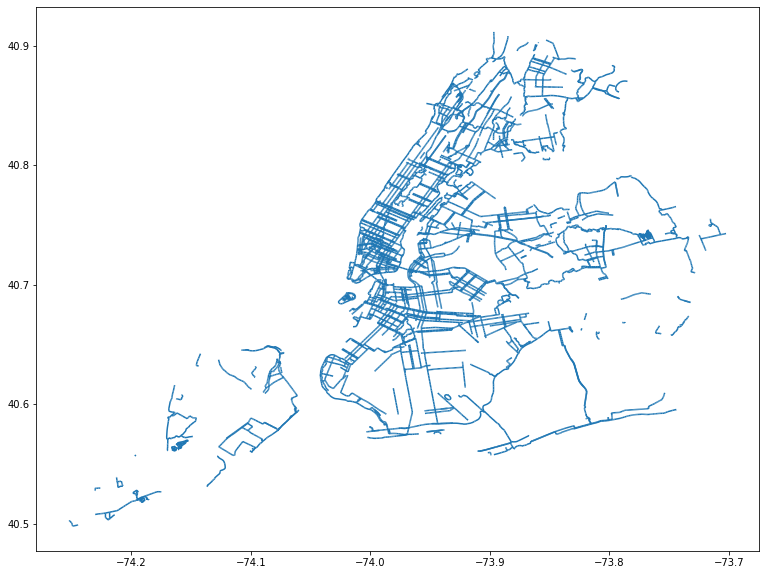

In [74]:
plt.rcParams['figure.figsize'] = (20, 10)
lanes.plot()

In [56]:
type(lanes.geometry[0])

shapely.geometry.multilinestring.MultiLineString

In [54]:
?folium.PolyLine

In [59]:
?folium.map.FeatureGroup

In [57]:
from shapely.geometry import MultiLineString

In [58]:
Manhattan = [40.76, -74.00]

m = folium.Map(location = Manhattan, tiles = 'OpenStreetMap', zoom_start = 12)
m.choropleth(geo_data = geospatial)

for i in range(lanes['geometry'].shape[0]):
    folium.PolyLine(lanes['geometry'][i]).add_to(m)

TypeError: Location should be a sized variable, for example a list or a tuple, instead got <shapely.geometry.linestring.LineString object at 0x139c1ad50> of type <class 'shapely.geometry.linestring.LineString'>.

# Citibike Analysis

In [3]:
bikes = pd.read_csv('data/citibike_data/2013-06-citibike-tripdata.csv')

In [8]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577703 entries, 0 to 577702
Data columns (total 15 columns):
tripduration               577703 non-null int64
starttime                  577703 non-null object
stoptime                   577703 non-null object
start station id           577703 non-null int64
start station name         577703 non-null object
start station latitude     577703 non-null float64
start station longitude    577703 non-null float64
end station id             559644 non-null float64
end station name           559644 non-null object
end station latitude       559644 non-null float64
end station longitude      559644 non-null float64
bikeid                     577703 non-null int64
usertype                   577703 non-null object
birth year                 337382 non-null float64
gender                     577703 non-null int64
dtypes: float64(6), int64(4), object(5)
memory usage: 66.1+ MB


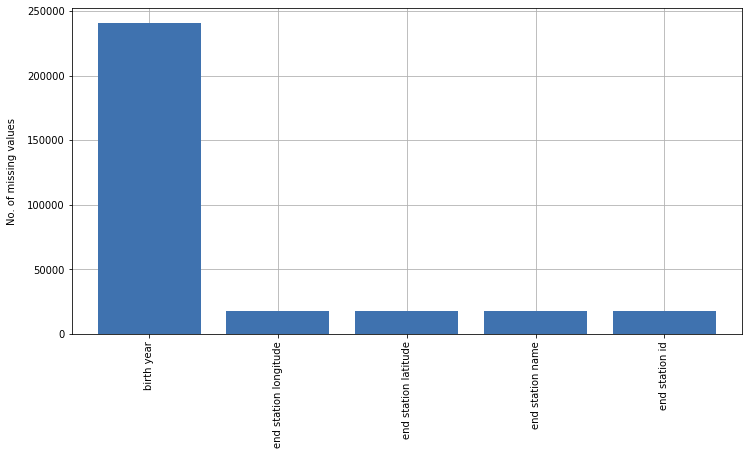

In [7]:
from mofo_bikes.src.d01_preparation import HelperFn as fn
fn.highest_NA(bikes)

In [36]:
print(bikes.usertype.unique())
print(bikes[bikes['usertype']=='Subscriber'].shape)
print(bikes[bikes['usertype']=='Customer'].shape)

['Subscriber' 'Customer']
(337384, 15)
(240319, 15)


In [8]:
# Convert Seconds to minutes
bikes['tripduration']  = bikes['tripduration']/60

In [9]:
# Remove 0 distance stations
bikes.describe()

tripduration  start station id  start station latitude  \
count  577703.000000     577703.000000           577703.000000   
mean       22.876171        439.228836               40.732436   
std       150.467717        337.240318                0.021423   
min         1.016667         72.000000               40.646607   
25%         8.566667        309.000000               40.717400   
50%        14.566667        404.000000               40.734546   
75%        23.300000        482.000000               40.749013   
max     64607.983333       3020.000000               40.771522   

       start station longitude  end station id  end station latitude  \
count            577703.000000   559644.000000         559644.000000   
mean                -73.991251      441.910624             40.732146   
std                   0.013002      345.448311              0.021507   
min                 -74.017134       72.000000             40.646607   
25%                 -74.001768      309.000000             40.716887   
50%                 -73.990741      403.000000             40.734232   
75%                 -73.981948      482.000000             40.748549   
max                 -73.950048     3020.000000             40.771522   

       end station longitude         bikeid     birth year         gender  
count          559644.000000  577703.000000  337382.000000  577703.000000  
mean              -73.991244   17617.434516    1974.644945       0.710431  
std                 0.013105    1677.518719      10.780255       0.678268  
min               -74.017134   14529.000000    1899.000000       0.000000  
25%               -74.001971   16161.000000    1968.000000       0.000000  
50%               -73.990741   17638.000000    1977.000000       1.000000  
75%               -73.981923   19066.000000    1983.000000       1.000000  
max               -73.950048   20625.000000    1997.000000       2.000000

In [10]:
import random
import os 
import glob #Unix style pathname pattern expansion
 #Changes direction to the folder

In [95]:
os.chdir('data/201307-201402-citibike-tripdata')

In [96]:
random.seed(0)
my_dfs = []
extension = 'csv'

# Uses glob fn from glob to match the extension pattern (csv). Written in regex

all_filenames = [i for i in glob.glob('*.{}'.format(extension) )]

i = 1
for csv in all_filenames:
    df_downsample = fn.pd_read_downsample(csv, 0.01)
    my_dfs.append(df_downsample)
    print('csv {} completed'.format(i))
    i += 1
    
fin_dat = pd.concat(my_dfs)

In [97]:
print(fin_dat.shape)
print(bikes.shape)

(55624, 15)
(577703, 15)


In [73]:
os.chdir('../..')

In [26]:
?fn.file_compressor

In [72]:
# Testing the file compressor with non-JS files
fn.file_compressor(
    startdir = 'data/201307-201402-citibike-tripdata',
    returndir = '../..',
    export = True
               )

csv 1 completed
csv 2 completed
csv 3 completed
csv 4 completed
csv 5 completed
csv 6 completed
csv 7 completed
csv 8 completed
csv 9 completed
csv 10 completed
Dataframe variable is set as finished_df
finished_df printed as combined_csv.csv
Complete!


In [21]:
finished_csv = pd.read_csv('data/201307-201402-citibike-tripdata/combined_csv.csv')

In [22]:
print(bikes.shape)
#print(fin_dat.shape)
#print(finished_df.shape)
print(finished_csv.shape)

(577703, 15)
(55624, 15)


In [13]:
from mofo_bikes.notebooks import HelperFn as fn

In [4]:
?fn.file_compressor

In [44]:
# Clean columan names
#js_csv = pd.read_csv('data/citibike_data/JC-201509-citibike-tripdata.csv')
js_csv = pd.read_csv('data/citibike_data/JC-201510-citibike-tripdata.csv')

In [45]:
js_csv.columns = js_csv.columns.str.lower()

In [46]:
js_csv.columns = js_csv.columns.str.replace(' ','')

In [47]:
#js_csv.to_csv('JC-201509-citibike-tripdata.csv',index = False)
js_csv.to_csv('JC-201510-citibike-tripdata.csv',index = False)

## Replicating Compression of Citibike data.
Prereq: You need to download all NYC citibike data from their website into a folder.

In [46]:
fn.file_compressor(
    startdir = 'data/citibike_data',
    returndir = '../..',
    percent = 5,
    export = True,
    name = 'five_yr_citibike.csv'
                  )

csv 1 completed
csv 2 completed
csv 3 completed
csv 4 completed
csv 5 completed
csv 6 completed
csv 7 completed
csv 8 completed
csv 9 completed
csv 10 completed
csv 11 completed
csv 12 completed
csv 13 completed
csv 14 completed
csv 15 completed
csv 16 completed
csv 17 completed
csv 18 completed
csv 19 completed
csv 20 completed
csv 21 completed
csv 22 completed
csv 23 completed
csv 24 completed
csv 25 completed
csv 26 completed
csv 27 completed
csv 28 completed
csv 29 completed
csv 30 completed
csv 31 completed
csv 32 completed
csv 33 completed
csv 34 completed
csv 35 completed
csv 36 completed
csv 37 completed
csv 38 completed
csv 39 completed
csv 40 completed
csv 41 completed
csv 42 completed
csv 43 completed
csv 44 completed
csv 45 completed
csv 46 completed
csv 47 completed
csv 48 completed
csv 49 completed
csv 50 completed
csv 51 completed
csv 52 completed
csv 53 completed
csv 54 completed
Dataframe variable is set as finished_df
finished_df printed as five_yr_citibike.csv
Comple

In [4]:
bike = pd.read_csv('data/five_yr_citibike.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032903 entries, 0 to 3032902
Data columns (total 15 columns):
tripduration             int64
starttime                object
stoptime                 object
startstationid           float64
startstationname         object
startstationlatitude     float64
startstationlongitude    float64
endstationid             float64
endstationname           object
endstationlatitude       float64
endstationlongitude      float64
bikeid                   int64
usertype                 object
birthyear                object
gender                   int64
dtypes: float64(6), int64(3), object(6)
memory usage: 347.1+ MB


In [44]:
os.chdir('../..')

In [45]:
!pwd

/Users/yasuhiro/Downloads/Project


# Reading Cleaned file

In [38]:
import random

In [39]:
random.seed(0)
n = sum(1 for line in open('data/concat_file_processed.csv')) - 1 #number of records in file (excludes header)
s = round(n*.25)
skip = sorted( random.sample(range(1,n+1), n-s)) #the 0-indexed header will not be included in the skip list
data = pd.read_csv('data/concat_file_processed.csv', skiprows = skip)

In [40]:
data = data.drop(['Unnamed: 0'], axis =1) # What is this column?

In [44]:
print(data.shape)
print(data.columns)
data.head()
data.sample()
data.info()
data.describe()

(1151339, 15)
Index(['bikeid', 'birthyear', 'endstationid', 'endstationlatitude',
       'endstationlongitude', 'endstationname', 'gender', 'startstationid',
       'startstationlatitude', 'startstationlongitude', 'startstationname',
       'starttime', 'stoptime', 'tripduration', 'usertype'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151339 entries, 0 to 1151338
Data columns (total 15 columns):
bikeid                   1151339 non-null int64
birthyear                1151339 non-null float64
endstationid             1151339 non-null float64
endstationlatitude       1151339 non-null float64
endstationlongitude      1151339 non-null float64
endstationname           1151339 non-null object
gender                   1151339 non-null int64
startstationid           1151339 non-null float64
startstationlatitude     1151339 non-null float64
startstationlongitude    1151339 non-null float64
startstationname         1151339 non-null object
starttime                1

bikeid     birthyear  endstationid  endstationlatitude  \
count  1.151339e+06  1.151339e+06  1.151339e+06        1.151339e+06   
mean   2.399666e+04  1.973463e+03  1.201126e+03        4.073635e+01   
std    6.891529e+03  2.230976e+01  1.301249e+03        5.991890e-02   
min    1.452900e+04  1.900000e+03  7.200000e+01        0.000000e+00   
25%    1.810400e+04  1.968000e+03  3.460000e+02        4.071911e+01   
50%    2.227700e+04  1.980000e+03  4.720000e+02        4.073705e+01   
75%    2.916900e+04  1.987000e+03  3.073000e+03        4.075456e+01   
max    4.204600e+04  2.003000e+03  3.918000e+03        4.081830e+01   

       endstationlongitude        gender  startstationid  \
count         1.151339e+06  1.151339e+06    1.151339e+06   
mean         -7.398541e+01  1.126711e+00    1.210346e+03   
std           9.907009e-02  5.513248e-01    1.304889e+03   
min          -7.404425e+01  0.000000e+00    7.200000e+01   
25%          -7.399725e+01  1.000000e+00    3.470000e+02   
50%          -7.398808e+01  1.000000e+00    4.730000e+02   
75%          -7.397706e+01  1.000000e+00    3.081000e+03   
max           0.000000e+00  2.000000e+00    3.918000e+03   

       startstationlatitude  startstationlongitude  tripduration  
count          1.151339e+06           1.151339e+06  1.151339e+06  
mean           4.073673e+01          -7.398535e+01  9.356704e+02  
std            2.674605e-02           1.743744e-02  9.552741e+03  
min            4.064661e+01          -7.403423e+01  6.000000e+01  
25%            4.071912e+01          -7.399724e+01  3.740000e+02  
50%            4.073726e+01          -7.398789e+01  6.170000e+02  
75%            4.075467e+01          -7.397681e+01  1.049000e+03  
max            4.081830e+01          -7.390070e+01  2.697582e+06

In [45]:
dup_rows = data[ data.duplicated() ] 
print('Number of duplicated rows: {}'.format(dup_rows.shape[0]) )
dup_ratio = dup_rows.shape[0]/data.shape[0] *100
print('Percent of rows that are duplicates {:.2f}%'.format(dup_ratio))

Number of duplicated rows: 72
Percent of rows that are duplicates 0.01%


In [46]:
data = data.drop_duplicates()

In [47]:
print( data.isnull().sum() ) 

bikeid                   0
birthyear                0
endstationid             0
endstationlatitude       0
endstationlongitude      0
endstationname           0
gender                   0
startstationid           0
startstationlatitude     0
startstationlongitude    0
startstationname         0
starttime                0
stoptime                 0
tripduration             0
usertype                 0
dtype: int64


In [57]:
# Convert column from object to datetime
data['starttime']= pd.to_datetime(data['starttime'])
data['stoptime']= pd.to_datetime(data['stoptime'])

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151267 entries, 0 to 1151338
Data columns (total 15 columns):
bikeid                   1151267 non-null int64
birthyear                1151267 non-null float64
endstationid             1151267 non-null float64
endstationlatitude       1151267 non-null float64
endstationlongitude      1151267 non-null float64
endstationname           1151267 non-null object
gender                   1151267 non-null int64
startstationid           1151267 non-null float64
startstationlatitude     1151267 non-null float64
startstationlongitude    1151267 non-null float64
startstationname         1151267 non-null object
starttime                1151267 non-null datetime64[ns]
stoptime                 1151267 non-null datetime64[ns]
tripduration             1151267 non-null float64
usertype                 1151267 non-null object
dtypes: datetime64[ns](2), float64(8), int64(2), object(3)
memory usage: 140.5+ MB


# Using Isochrone mapping

In [4]:
#conda install -c conda-forge rtree
#!pip install osmnx

  Using cached osmnx-0.11.4-py2.py3-none-any.whl (77 kB)
  Using cached networkx-2.4-py3-none-any.whl (1.6 MB)
  Using cached pandas-1.0.2-cp37-cp37m-macosx_10_9_x86_64.whl (9.8 MB)
ERROR: pandas-profiling 2.5.0 has requirement pandas==0.25.3, but you'll have pandas 1.0.2 which is incompatible.
  Attempting uninstall: networkx
    Found existing installation: networkx 2.3
    Uninstalling networkx-2.3:
      Successfully uninstalled networkx-2.3
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


## Docking stations

In [9]:
bikes2020 = pd.read_csv('data/citibike_data/202001-citibike-tripdata.csv')

In [13]:
bikes2020.columns = bikes2020.columns.str.replace(' ', "_")

In [16]:
#Identify the most popular dock stations
bikes2020.start_station_id.value_counts().describe()

count      893.000000
mean      1389.245241
std       1456.863449
min          2.000000
25%        324.000000
50%        843.000000
75%       2069.000000
max      10734.000000
Name: start_station_id, dtype: float64

In [20]:
#Identify the amount of activity in a day
bikes2020['starttime']= pd.to_datetime(bikes2020['starttime'])
bikes2020['stoptime']= pd.to_datetime(bikes2020['stoptime'])

In [43]:
bikes2020['start_hour'] = bikes2020.starttime.apply(lambda l: l.hour)

In [27]:
bikes2020.starttime.apply(lambda l: l.hour).value_counts().sort_index()
bikes2020.stoptime.apply(lambda l: l.hour).value_counts().sort_index()

0       9548
1       5682
2       3659
3       2327
4       2532
5       9272
6      29218
7      63273
8     113714
9      83333
10     54982
11     57988
12     66714
13     69819
14     73202
15     77971
16     89073
17    119933
18    110242
19     74634
20     49379
21     33802
22     24500
23     15799
Name: starttime, dtype: int64

In [60]:
#Identify the amount of activity in a day for each station
dock_activity = bikes2020.groupby(['start_station_id','start_hour']).count()

start_station_id  start_hour
359               17            1439
                  18            1053
402               17            1113
                  18            1220
519               7             1046
                  8             1462
                  9             1042
                  17            1321
                  18            1132
3255              6             1092
                  7             1442
                  8             1177
3443              17            1011
3664              17            1399
Name: tripduration, dtype: int64

In [ ]:
# Visualize highest activity
highest_traffic = dock_activity.tripduration[dock_activity.tripduration > 1000]

In [35]:
bikes2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240596 entries, 0 to 1240595
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   tripduration             1240596 non-null  int64         
 1   starttime                1240596 non-null  datetime64[ns]
 2   stoptime                 1240596 non-null  datetime64[ns]
 3   start_station_id         1240596 non-null  int64         
 4   start_station_name       1240596 non-null  object        
 5   start_station_latitude   1240596 non-null  float64       
 6   start_station_longitude  1240596 non-null  float64       
 7   end_station_id           1240596 non-null  int64         
 8   end_station_name         1240596 non-null  object        
 9   end_station_latitude     1240596 non-null  float64       
 10  end_station_longitude    1240596 non-null  float64       
 11  bikeid                   1240596 non-null  int64         
 12  